In [1]:
import torch
import torch.nn as nn
import numpy as np
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

# neuromancer
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Problem Formulation

We solve the following MIQP problem:
$$
\begin{align}
&\text{minimize } && \mathbf{x}^T \mathbf{x} + \mathbf{p}^T \mathbf{x} \\
&\text{subject to} && \mathbf{x} \le \mathbf{b}, \\
& && \mathbf{1}^T \mathbf{x} \le a, \\
& && \mathbf{x} \le M \mathbf{y}, \\
& && \mathbf{1}^T \mathbf{y} \le 1,
\end{align}
$$
where $\mathbf{x} \in \mathbb{R}^2$ and $\mathbf{y} \in \{0,1\}^2$ are the continuous and binary optimization variables. The parameters include $\mathbf{p}$, $\mathbf{b}$, and $a$.


# Data generation

In [2]:
nx = 2 #  number of continuous decision variables
ny = 2 #  number of integer decision variables
data_seed = 18 # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

p_low, p_high = -30.0, 5.0 # linear term in the objective x.T*x + p.T*x
b_low, b_high = 5.0, 25.0 # RHS of the constraint x <= b
a_low, a_high = 10.0, 30.0 # RHS of the constraint 1.T*x <= a

ntrain = 5000  # number of datapoints: increase sample density for more robust results
ntest = 500 
samples_train = {"p": torch.FloatTensor(ntrain, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntrain, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntrain, 1).uniform_(a_low, a_high),
                }
samples_dev = {"p": torch.FloatTensor(ntrain, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntrain, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntrain, 1).uniform_(a_low, a_high),
                }
samples_test = {"p": torch.FloatTensor(ntest, nx).uniform_(p_low, p_high),
                "b": torch.FloatTensor(ntest, nx).uniform_(b_low, b_high),
                "a": torch.FloatTensor(ntest, 1).uniform_(a_low, a_high),
                }
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)


# MLP block with Straight-Through Estimator (STE) for rounding

In [3]:
from neuromancer.modules.blocks import Block, MLP
import neuromancer.slim as slim
from neuromancer.modules.activations import soft_exp, SoftExponential, SmoothedReLU

# STE_Round operator; see https://arxiv.org/pdf/1308.3432
class STE_Round(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

class MLPWithSTE(Block):
    """
    Multi-Layer Perceptron consistent with blocks interface
    Using STE_Round operator defined above for the classifier
    """
    def __init__(
        self,
        insize,
        outsize,
        bias=True,
        linear_map=slim.Linear,
        nonlin=SoftExponential,
        hsizes=[64],
        linargs=dict(),
    ):
        """
        :param insize: (int) dimensionality of input
        :param outsize: (int) dimensionality of output
        :param bias: (bool) Whether to use bias
        :param linear_map: (class) Linear map class from neuromancer.slim.linear
        :param nonlin: (callable) Elementwise nonlinearity which takes as input torch.Tensor and outputs torch.Tensor of same shape
        :param hsizes: (list of ints) List of hidden layer sizes
        :param linargs: (dict) Arguments for instantiating linear layer
        :param dropout: (float) Dropout probability
        """
        super().__init__()
        self.in_features, self.out_features = insize, outsize
        self.nhidden = len(hsizes)
        sizes = [insize] + hsizes + [outsize]
        self.nonlin = nn.ModuleList(
            [nonlin() for k in range(self.nhidden)] + [nn.Identity()]
        )
        self.linear = nn.ModuleList(
            [
                linear_map(sizes[k], sizes[k + 1], bias=bias, **linargs)
                for k in range(self.nhidden + 1)
            ]
        )

    def reg_error(self):
        return sum([k.reg_error() for k in self.linear if hasattr(k, "reg_error")])

    def block_eval(self, x):
        """
        :param x: (torch.Tensor, shape=[batchsize, insize])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        for lin, nlin in zip(self.linear, self.nonlin):
            x = nlin(lin(x))
        probs = torch.sigmoid(x)
        hard_output = STE_Round.apply(probs)
        return hard_output

# Using CVXPY projection layer

We utilize 2 separate MLP networks for learning x and y. The outputs of MLPs go through a CVXPY projection layer to guarantee linear constraints.


In [4]:
# mapping problem parameters to integer decision variables
# input size should be for concatenated vector of p, b, a
int_func = MLPWithSTE(insize=2*nx+1, outsize=ny,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[128] * 4)
int_sol_map = Node(int_func, ['p', 'b', 'a'], ['y'], name='int_map')

In [5]:
# mapping problem parameters to continuous decision variables
# input size should be for concatenated vector of p, b, a
cont_func = MLP(insize=2*nx+1, outsize=nx,
                bias=True,
                linear_map=torch.nn.Linear,
                nonlin=nn.ReLU,
                hsizes=[128] * 4)
cont_sol_map = Node(cont_func, ['p', 'b', 'a'], ['x'], name='cont_map')

In [6]:
# Continuous variables
x = variable("x")
x1 = x[:, [0]]; x2 = x[:, [1]] 
# Binary variables
y = variable("y")
y1 = y[:, [0]]; y2 = y[:, [1]] 

# problem parameters sampled in the dataset
p1 = variable('p')[:, [0]]; p2 = variable('p')[:, [1]] # ; b3 = variable('b')[:, [2]]; b4 = variable('b')[:, [3]]
a = variable('a')

f = (x1+p1/2)**2 + (x2+p2/2)**2
obj = f.minimize(weight=1.0, name='obj')

bigM = 1e3
Q_con = 1e3
g1 =  y1 + y2 - 1.0 
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'

constraints = [con_1]

In [7]:
y_net = cp.Parameter(ny) # binary decision from neural net
x_net = cp.Parameter(nx) # continuouis decision from neural net
x_cvxpy = cp.Variable(ny) # cvxpy decision variable
A_cvxpy = np.vstack([np.eye(nx), np.ones((1,nx))])
b_cvxpy = cp.Parameter(nx)
a_cvxpy = cp.Parameter(1)

# projection problem formulation
cvxpy_obj = cp.Minimize(1.0 * cp.sum_squares(x_cvxpy - x_net))
cvxpy_cons = [x_cvxpy@A_cvxpy.T <= cp.hstack([b_cvxpy, a_cvxpy]), \
              x_cvxpy <= bigM*y_net]
cvxpy_prob = cp.Problem(cvxpy_obj, cvxpy_cons)
# cvxpy layer
cvxpy_layer = CvxpyLayer(cvxpy_prob,
                   parameters=[b_cvxpy, a_cvxpy, y_net, x_net],
                   variables=[x_cvxpy])
# symbolic wrapper: sol_map(bparam, xy) -> xy
project = Node(cvxpy_layer, ['b', 'a', 'y', 'x'], ['x_cvx'], name='qp')

In [8]:
# corrected variable by the cvxpy layer
x_cvx = variable("x_cvx")
# cvxpy-supervised loss for the neural net
residual = torch.abs(x - x_cvx)
cvxp_loss = 1.*(residual == 0)

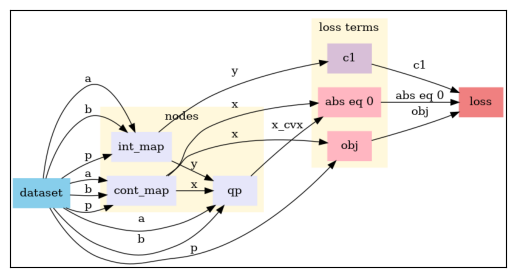

In [9]:
# constrained optimization problem construction
nodes = [int_sol_map, cont_sol_map, project]
objectives = [obj, cvxp_loss]

# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(nodes, loss)
# plot computational graph
problem.show()

In [12]:
lr = 1e-4      # step size for gradient descent
epochs = 10    # number of training epochs
warmup = 10    # number of epochs to wait before enacting early stopping policy
patience = 10  # number of epochs with no improvement in eval metric to allow before early stopping

In [13]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

In [14]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 297.9198303222656
epoch: 1  train_loss: 222.70364379882812
epoch: 2  train_loss: 192.20901489257812
epoch: 3  train_loss: 209.87254333496094
epoch: 4  train_loss: 195.03250122070312
epoch: 5  train_loss: 188.31564331054688
epoch: 6  train_loss: 208.15139770507812
epoch: 7  train_loss: 209.99305725097656
epoch: 8  train_loss: 224.42984008789062
epoch: 9  train_loss: 202.1628875732422


/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([20, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


<All keys matched successfully>

### A single test case

In [15]:
# Test case
# Solution from Neuromancer
a = [15.0]; b = [12.0, 15.0]; p = [-20.0, -12.0]
datapoint = {'a': torch.tensor([a]), 'b': torch.tensor([b]), 'p': torch.tensor([p]),
             'name': 'test'}
model_out = problem(datapoint)
x_nm = model_out['test_' + "x_cvx"][0].detach().numpy()
y_nm = model_out['test_' + "y"][0].detach().numpy()
print(x_nm, y_nm)


[-7.5449891e-05  5.6915402e+00] [0. 1.]


/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


In [16]:
# Baseline Solution of the MIQP problem with GUROBI.
def MIQP_param(p, b, a):
    # Variables
    x = cp.Variable(nx)
    y = cp.Variable(ny, boolean=True)  # declare binary variables

    # Objective and constraints
    objective = cp.Minimize(cp.sum_squares((x + np.array(p)/2)))
    constraints = [
        x <= np.array(b),
        cp.sum(x) <= a,
        cp.sum(y) <= 1,
        x <= bigM * y
    ]

    # Problem definition
    prob = cp.Problem(objective, constraints)

    # Solve with Gurobi
    prob.solve(solver=cp.GUROBI, verbose=False)

    return x.value, y.value

print(MIQP_param(p, b, a))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-27
(array([10.,  0.]), array([1., 0.]))


# Test with dataset

It seems the trained model may produce feasible but highly sub-optimal solutions. 

In [17]:
"""
Benchmark Solution
"""
def eval_constraints(x, y, b, a):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y[0] + y[1] - 1.0)
    con_2_viol = np.maximum(0, x[0] - b[0])
    con_3_viol = np.maximum(0, x[1] - b[1])
    con_4_viol = np.maximum(0, x[0] + x[1] - a)
    con_5_viol = np.maximum(0, x[0] - bigM*y[0])
    con_6_viol = np.maximum(0, x[1] - bigM*y[1])

    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol  + con_5_viol + con_6_viol
    
    return con_viol

def eval_objective(x, y, p):
    obj_value = np.sum((x+p/2)**2)
    return obj_value

# Solve via neuromancer
samples_test['name'] = 'test'
model_out = problem(samples_test)
x_nm = model_out['test_' + "x_cvx"].detach().numpy()
y_nm = model_out['test_' + "y"].detach().numpy()

# Solve via solver
x_solver, y_solver = [], []
for i in range(0, ntest):
    p_test = samples_test['p'][i].detach().numpy()
    b_test = samples_test['b'][i].detach().numpy()
    a_test = samples_test['a'][i].detach().numpy()

    x_sol, y_sol = MIQP_param(p_test, b_test, a_test)
    x_solver.append(x_sol)
    y_solver.append(y_sol)

x_grb = np.asarray(x_solver)
y_grb = np.asarray(y_solver)

/home/vietanhle/github/phdenv/lib/python3.10/site-packages/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([500, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


In [18]:
# Evaluate neuromancer solution
nm_violation = []
grb_violation = []
nm_cost = []
grb_cost = []

for i in range(ntest):
    p_test = samples_test['p'][i].detach().numpy()
    b_test = samples_test['b'][i].detach().numpy()
    a_test = samples_test['a'][i].detach().numpy()
    nm_violation.append(eval_constraints(x_nm[i,:], y_nm[i,:], b_test, a_test))
    grb_violation.append(eval_constraints(x_grb[i,:], y_grb[i,:], b_test, a_test))

    nm_cost.append(eval_objective(x_nm[i,:], y_nm[i,:], p_test))
    grb_cost.append(eval_objective(x_grb[i,:], y_grb[i,:], p_test))

print(f'Neuromancer mean constraints violation {np.mean(nm_violation):.4f}')
print(f'Neuromancer mean cost {np.mean(nm_cost):.4f}')


print(f'GUROBI mean constraints violation {np.mean(grb_violation):.4f}')
print(f'GUROBI mean cost {np.mean(grb_cost):.4f}')



Neuromancer mean constraints violation 0.0061
Neuromancer mean cost 73.8405
GUROBI mean constraints violation 0.0000
GUROBI mean cost 32.1257
